![EDA](../5_Sources/Images/banner_eda.gif)

# <h2 align=center>**`EDA Google Maps`**</h2>

Importando las librerías

In [22]:
import pandas as pd
import numpy as np
from datetime import datetime
import ast
import seaborn as sns
import matplotlib.pyplot as plt

>**`Dataset 'df_estados.csv'`**

Importar el dataset

In [23]:
# Load data into pandas DataFrame from "/lakehouse/default/" + "Files/data/original/Google/df_estados.csv"
#df_estados = pd.read_csv("/lakehouse/default/" + "Files/data/original/Google/df_estados.csv")

df_estados = pd.read_csv('df_estados.csv', encoding='UTF-8')

#Descartando la primera columna del dataframe ya que no es necesaria
df_estados= df_estados.iloc[:,2:]
pd.options.display.max_columns=0
df_estados.head(2)

,name_x,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,category_hotel,user_id,name_y,time,rating,text,pics,resp,estado
0,Holiday Inn Express & Suites Fultondale,"Holiday Inn Express & Suites Fultondale, 1733 ...",0x88890491e9416625:0x2f85307a06ddb16,Unfussy rooms & suites in a relaxed hotel offe...,33.609814,-86.807733,['Hotel'],3.7,38,NaN,NaN,NaN,NaN,"['0x88890492ef4ca701:0x34f0c46c887eaf73', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,Hotel,1.126652e+20,Charlie Cline,1454821094934,4,Good location. Nice staff. Clean. Breakfast ar...,NaN,NaN,Alabama
1,Holiday Inn Express & Suites Fultondale,"Holiday Inn Express & Suites Fultondale, 1733 ...",0x88890491e9416625:0x2f85307a06ddb16,Unfussy rooms & suites in a relaxed hotel offe...,33.609814,-86.807733,['Hotel'],3.7,38,NaN,NaN,NaN,NaN,"['0x88890492ef4ca701:0x34f0c46c887eaf73', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,Hotel,1.086380e+20,Jennifer Passmore,1491966256419,5,Super clean very friendly,NaN,NaN,Alabama


Verificar el tipo de dato de cada columna y la existencia de valores nulos

In [24]:
df_estados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58216 entries, 0 to 58215
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name_x            58216 non-null  object 
 1   address           58196 non-null  object 
 2   gmap_id           58216 non-null  object 
 3   description       38407 non-null  object 
 4   latitude          58216 non-null  float64
 5   longitude         58216 non-null  float64
 6   category          58216 non-null  object 
 7   avg_rating        58216 non-null  float64
 8   num_of_reviews    58216 non-null  int64  
 9   price             0 non-null      float64
 10  hours             0 non-null      float64
 11  MISC              10746 non-null  object 
 12  state             0 non-null      float64
 13  relative_results  56268 non-null  object 
 14  url               58216 non-null  object 
 15  category_hotel    58216 non-null  object 
 16  user_id           58216 non-null  float6

Conocer el número de filas y columnas del dataframe

In [25]:
df_estados.shape

(58216, 24)

Se realiza un heatmap para visualizar los campos que contegan valores nulos

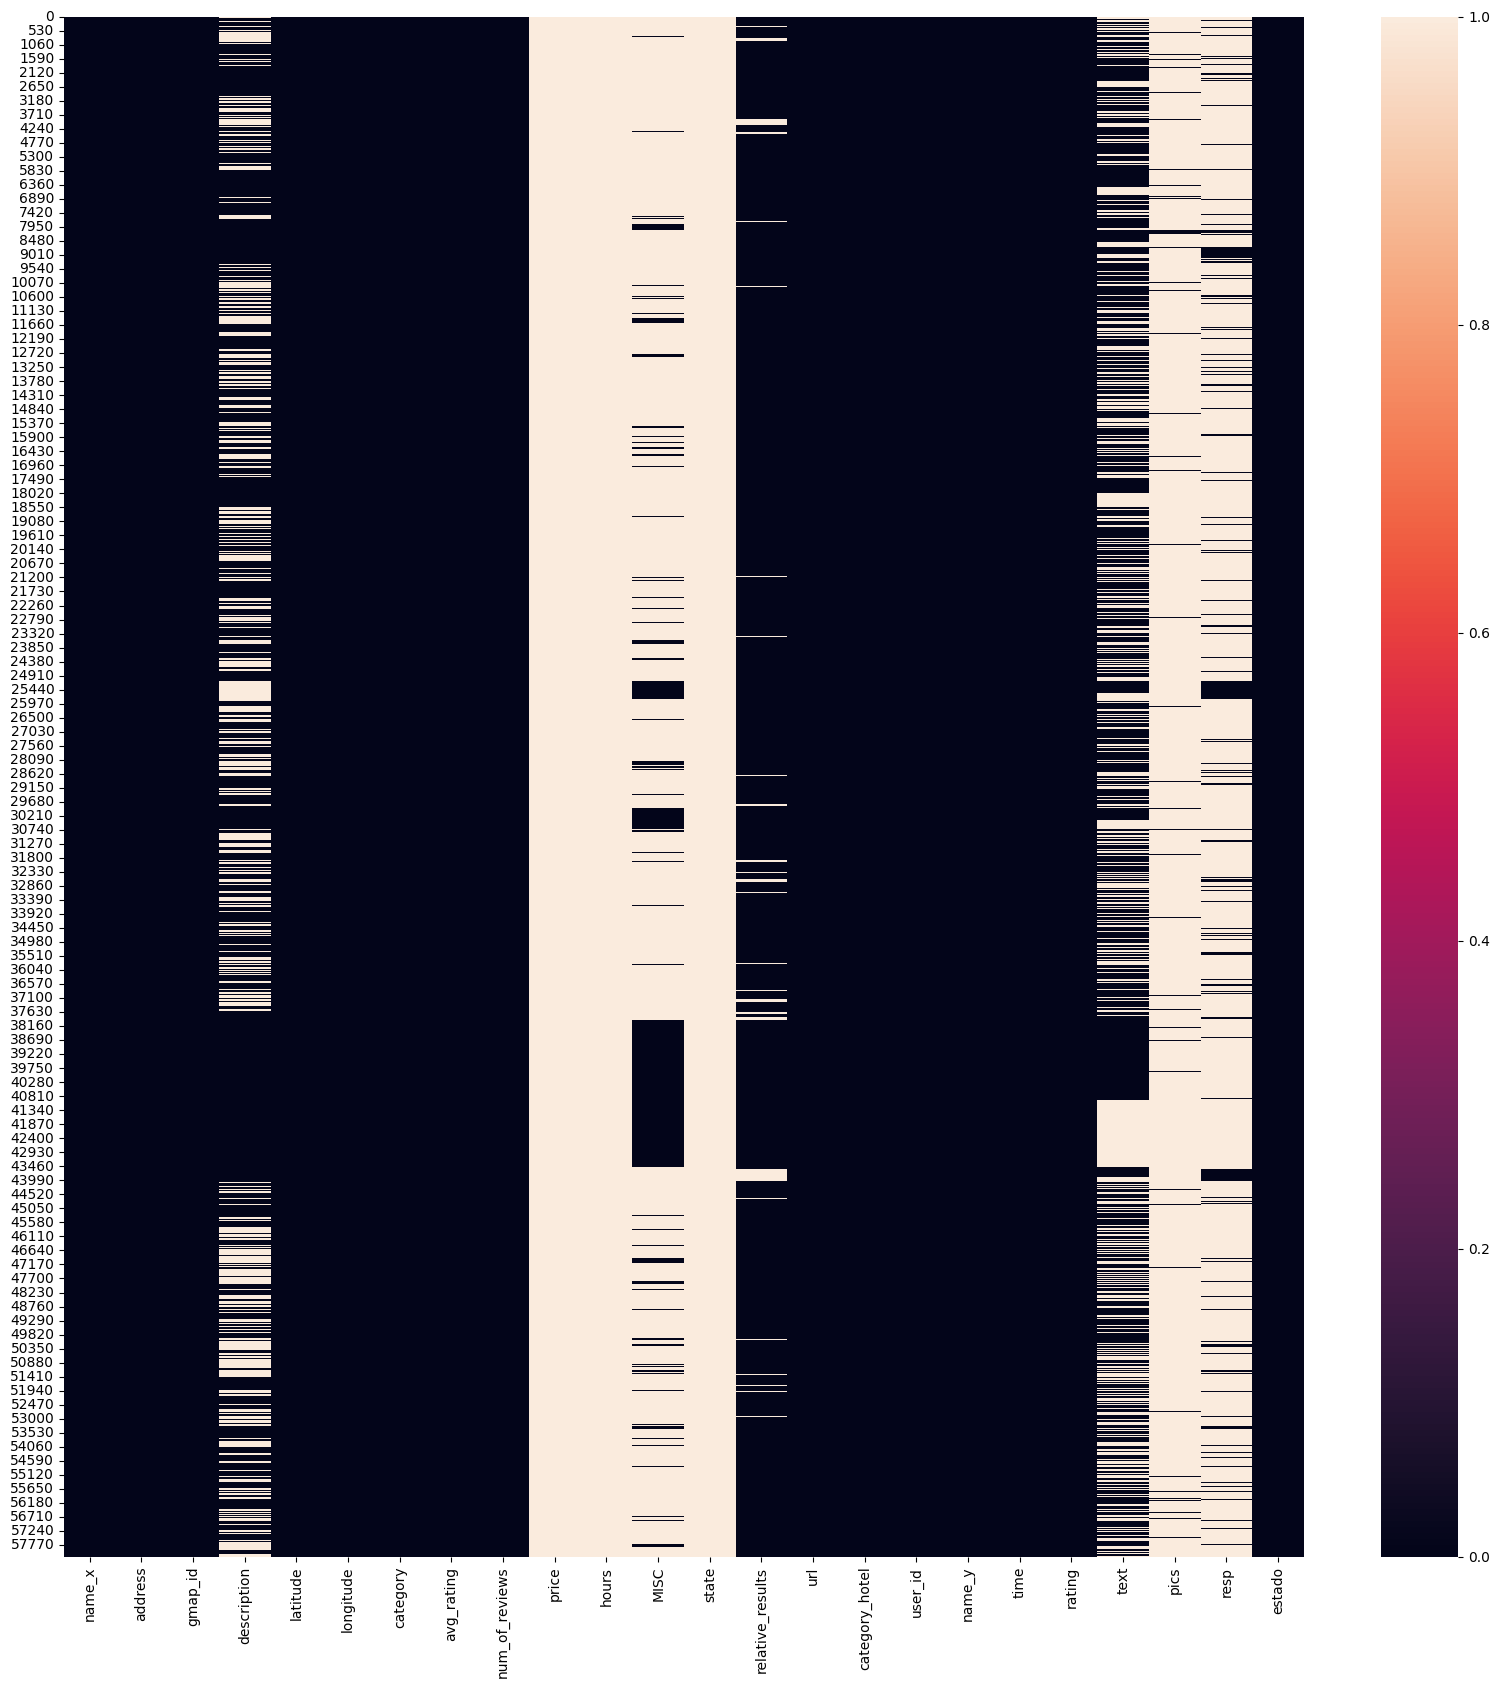

In [26]:
#Graficando mapa de calor para conocer visualmente la existencia de valores nulos
plt.figure(figsize=[20,20])
sns.heatmap(df_estados.isnull()) 
plt.show()

Se destacan las columnas "price", "hours" y "state", pues estas se encuentran sin datos, por lo tanto se toma la decisión de eliminarlas. Asímismo se renombran las columnas con las que se va a trabajar para un mejor entendimiento y se transforma el tipo de dato de la columna "time", que está en formato UNIX, a formato fecha.

In [27]:
#Seleccionando las columnas del dataframe que se van a usar y renombrándolas para un mejor entendimiento
df_estados = df_estados.loc[:,['estado', 'name_y', 'rating', 'text', 'time',
                               'name_x', 'address', 'gmap_id', 'description', 'latitude', 'longitude',
                               'category', 'avg_rating', 'num_of_reviews', 'MISC', 'relative_results', 'url'
                               ]].rename(columns={'estado':'state', 'name_x':'name_hotel', 'name_y':'name_user', 
                                                  'rating':'rating_user', 'text':'text_user', 'time':'time_user'})
df_estados['time_user'] = df_estados['time_user'].apply( lambda x: datetime.fromtimestamp(x//1000).date() ) #tranformar formato UNIX a formato fecha
df_estados.head(2)

,state,name_user,rating_user,text_user,time_user,name_hotel,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,MISC,relative_results,url
0,Alabama,Charlie Cline,4,Good location. Nice staff. Clean. Breakfast ar...,2016-02-06,Holiday Inn Express & Suites Fultondale,"Holiday Inn Express & Suites Fultondale, 1733 ...",0x88890491e9416625:0x2f85307a06ddb16,Unfussy rooms & suites in a relaxed hotel offe...,33.609814,-86.807733,['Hotel'],3.7,38,NaN,"['0x88890492ef4ca701:0x34f0c46c887eaf73', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
1,Alabama,Jennifer Passmore,5,Super clean very friendly,2017-04-11,Holiday Inn Express & Suites Fultondale,"Holiday Inn Express & Suites Fultondale, 1733 ...",0x88890491e9416625:0x2f85307a06ddb16,Unfussy rooms & suites in a relaxed hotel offe...,33.609814,-86.807733,['Hotel'],3.7,38,NaN,"['0x88890492ef4ca701:0x34f0c46c887eaf73', '0x8...",https://www.google.com/maps/place//data=!4m2!3...


Se realiza nuevamente un heatmap para visualizar las columnas (y datos nulos) con las que quedó el dataframe.

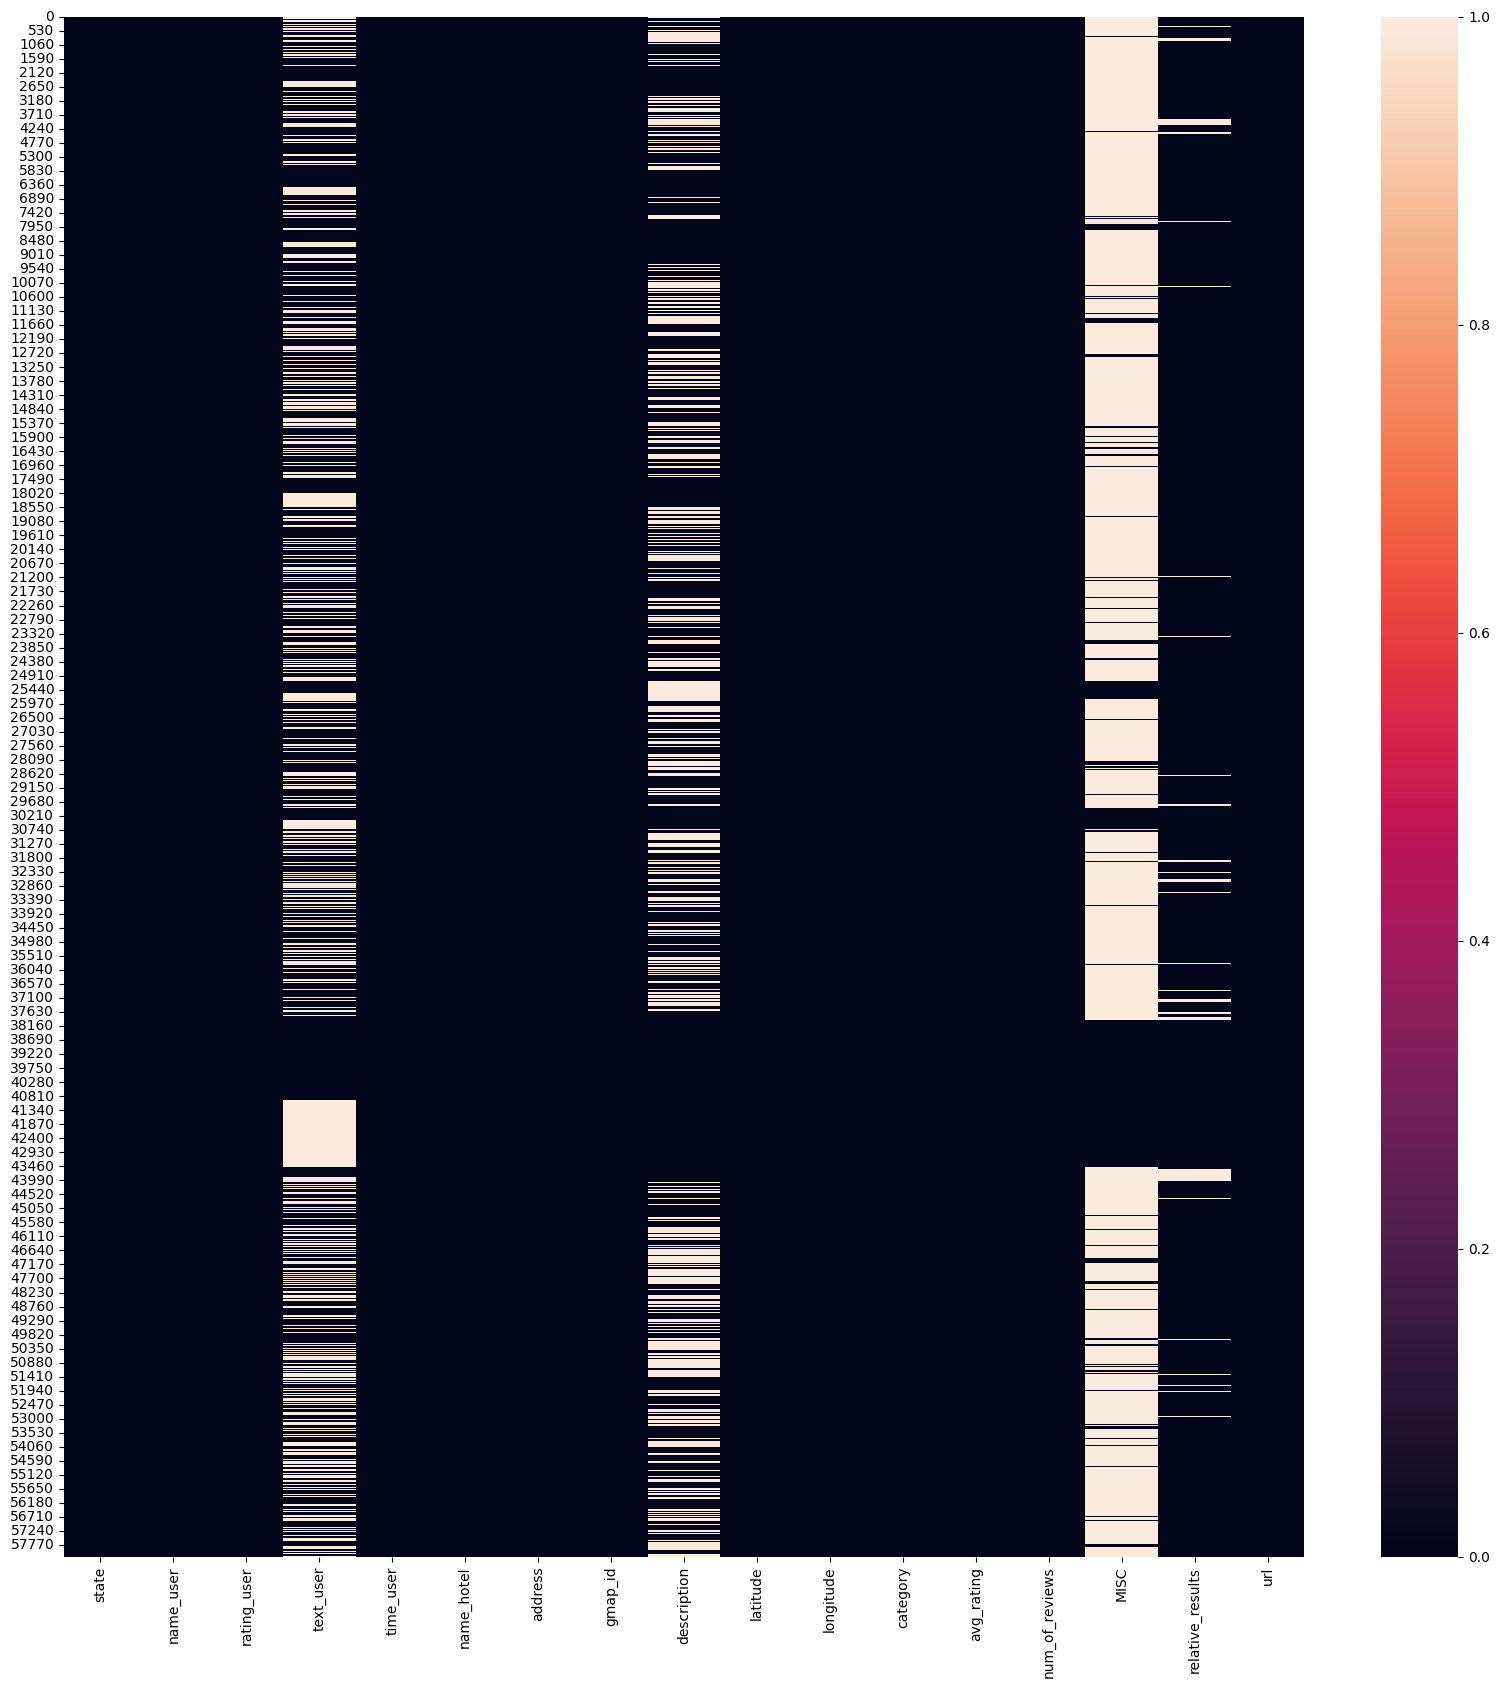

In [30]:
plt.figure(figsize=[20,20])
sns.heatmap(df_estados.isnull()) 
plt.show()

Se destaca que el dataframe cuenta ahora con 17 columnas, de las cuales 'text_user', 'description', 'MISC' y 'relative_results' tienen campos vacíos, sin embargo permanecen en el dataset ya que se considera que su información será de utilidad para análisis posteriores.

Por otra parte, se procede a normalizar el dataframe con el objetivo de minimizar la redundancia de datos y una facilidad de gestión posterior. Para ello se separa en 2 dataframes quedando relacionados por la columna 'state' y 'name_hotel'.

In [31]:
#'df_estados' se separa en 'df_state'
df_state = df_estados.drop_duplicates(df_estados.columns[df_estados.columns.isin(['name_hotel'])])
df_state = df_state.loc[:,['state', 'name_hotel', 'address', 'gmap_id', 'description', 'latitude', 'longitude',
                'category', 'avg_rating', 'num_of_reviews', 'MISC', 'relative_results', 'url']].reset_index(drop=True)
df_state.to_csv('df_state.csv') #exportar dataframe
df_state.head(3)


,state,name_hotel,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,MISC,relative_results,url
0,Alabama,Holiday Inn Express & Suites Fultondale,"Holiday Inn Express & Suites Fultondale, 1733 ...",0x88890491e9416625:0x2f85307a06ddb16,Unfussy rooms & suites in a relaxed hotel offe...,33.609814,-86.807733,['Hotel'],3.7,38,NaN,"['0x88890492ef4ca701:0x34f0c46c887eaf73', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
1,Alabama,Budgetel Inn,"Budgetel Inn, 2201 Memorial Pkwy NW, Huntsvill...",0x88626b3eef6314db:0x1c0b19d1d69d1d24,NaN,34.752274,-86.597270,['Hotel'],2.7,74,NaN,"['0x88626b3eb9167bb3:0xf33d2565718a284d', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
2,Alabama,Windwood Inn,"Windwood Inn, 610 McMeans Ave, Bay Minette, AL...",0x889a8a0f16241c7d:0xae32fa59c5d63398,Budget pick offering free continental breakfas...,30.884019,-87.786858,['Hotel'],3.3,74,NaN,"['0x889a89e8488b1949:0x6fc6bed199865bf8', '0x8...",https://www.google.com/maps/place//data=!4m2!3...


In [32]:
#'df_estados' se separa en 'df_reviews' que contiene las reseñas de los usuarios
df_reviews = df_estados.loc[:,['state', 'name_hotel', 'name_user', 'rating_user', 'text_user', 'time_user']]
df_reviews.to_csv('df_reviews.csv') #exportar dataframe
df_reviews.head(2)

,state,name_hotel,name_user,rating_user,text_user,time_user
0,Alabama,Holiday Inn Express & Suites Fultondale,Charlie Cline,4,Good location. Nice staff. Clean. Breakfast ar...,2016-02-06
1,Alabama,Holiday Inn Express & Suites Fultondale,Jennifer Passmore,5,Super clean very friendly,2017-04-11


Aunque se realizó una normalización del dataframe principal se usará este para conocer, a través de un heatmap, la correlación existente entre las variables numéricas.

<Axes: >

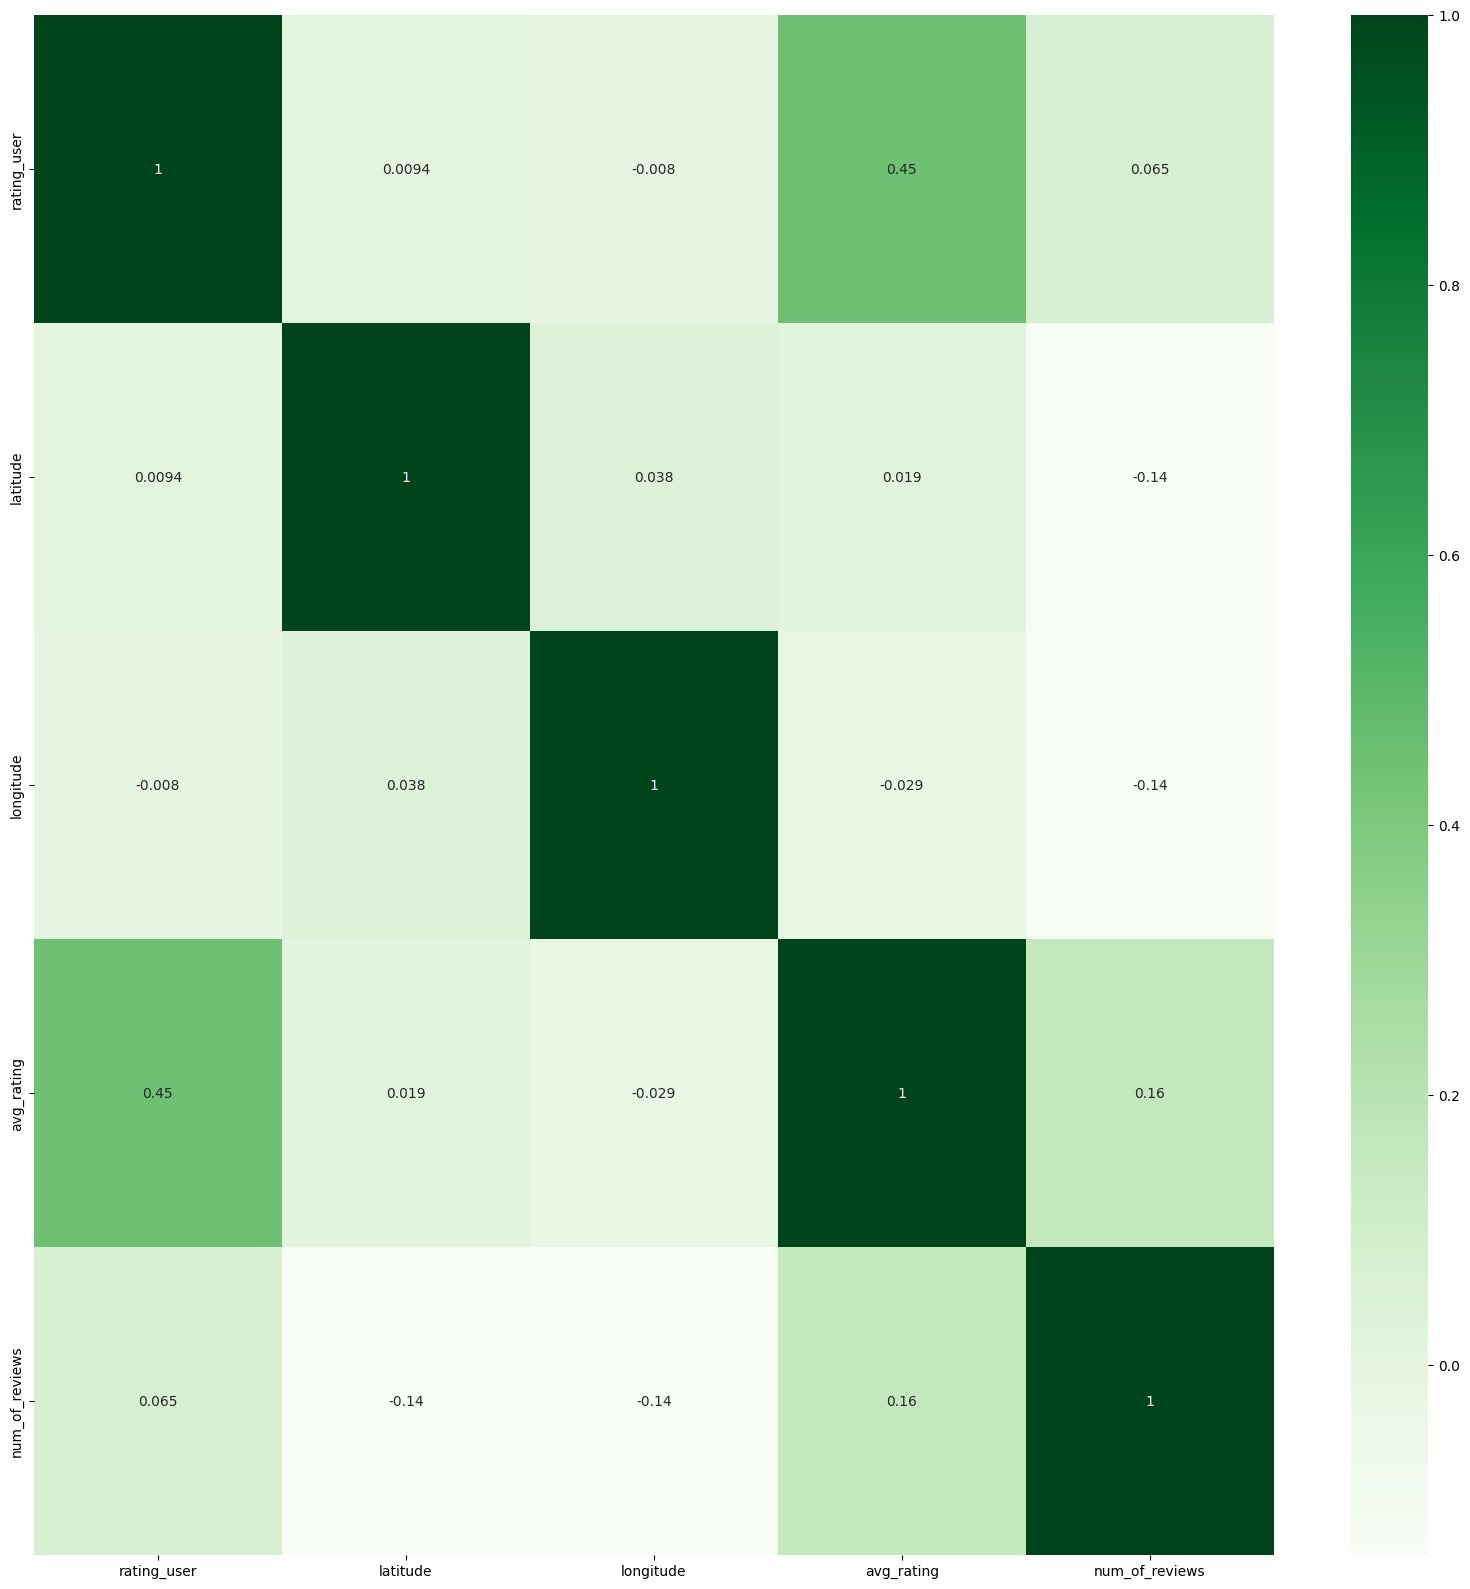

In [33]:
correlac = df_estados.corr(numeric_only = True)
plt.figure(figsize=[20,20])
sns.heatmap(correlac, annot=True, cmap='Greens')

Observando el gráfico, podemos concluir que las variables no estan correlacionadas en un rango significativo pues el valor más alto de correlación es de 0.45 que se da entre 'rating_user' y 'avg_rating'.


Continuando con el análisis se procede a calcular y visualizar la cantidad de opiniones presentadas por los usuarios en cada estado.

In [34]:
state_reviews = df_state.drop_duplicates(df_estados.columns[df_estados.columns.isin(['state'])], keep='first').groupby('state')['num_of_reviews'].sum().reset_index(name="num_reviews")
state_reviews

,state,num_reviews
0,Alabama,38
1,Alaska,45
2,Arizona,24
3,Arkansas,18
4,California,48
5,Colorado,258
6,Connecticut,117
7,Delaware,26
8,District_of_Columbia,198
9,Florida,46


Se procede a crear un histograma de frecuencia para observar la distribución de los datos

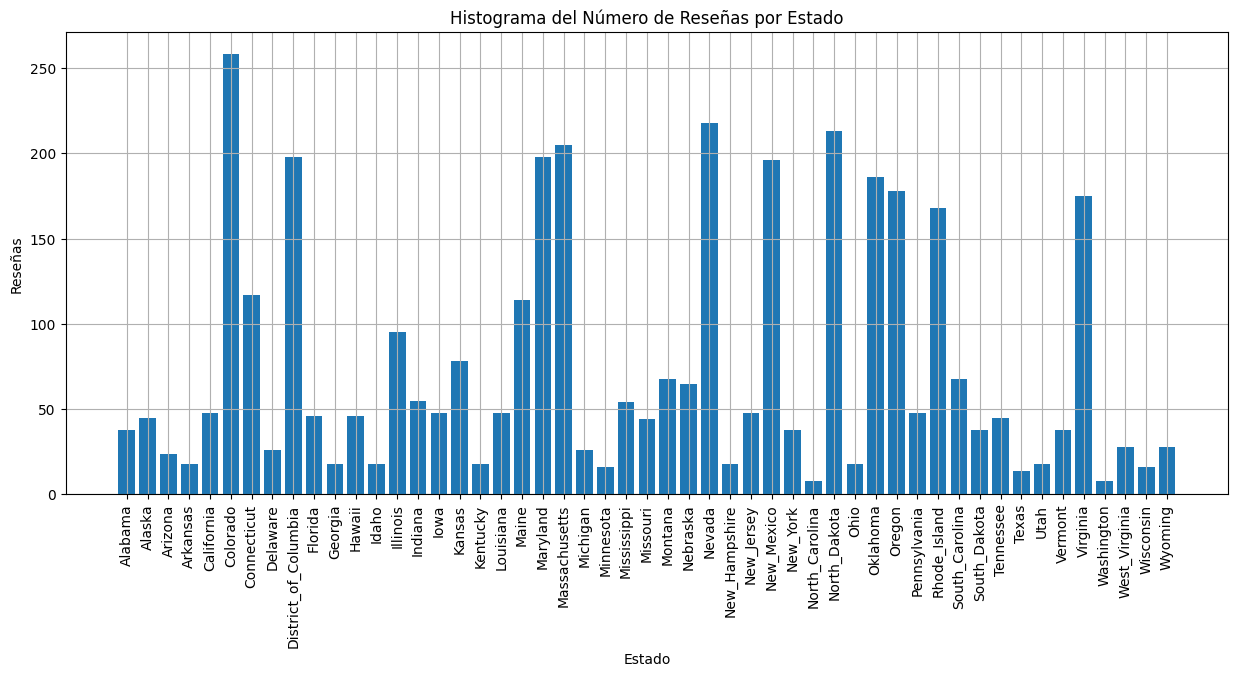

In [35]:
plt.figure(figsize=(15, 6))
plt.bar(state_reviews['state'], state_reviews['num_reviews'])
plt.xlabel('Estado')
plt.ylabel('Reseñas')
plt.title('Histograma del Número de Reseñas por Estado')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Se observa que la mayor cantidad de reseñas de los usuarios es en el estado de Colorado con un total de 258, seguido de Nevada con 218 y Massachusetts con 205; por otra parte los estados que tienen una menor cantidad son North Carolina y Washington con 8 reseñas en total.

También se calcula y visualiza la cantidad de hoteles que existen en cada estado.

In [44]:
num_hotels = df_state.groupby('state')['name_hotel'].count().reset_index(name='num_hotels')
num_hotels

,state,num_hotels
0,Alabama,35
1,Alaska,2
2,Arizona,39
3,Arkansas,16
4,California,83
5,Colorado,45
6,Connecticut,14
7,Delaware,1
8,District_of_Columbia,1
9,Florida,75


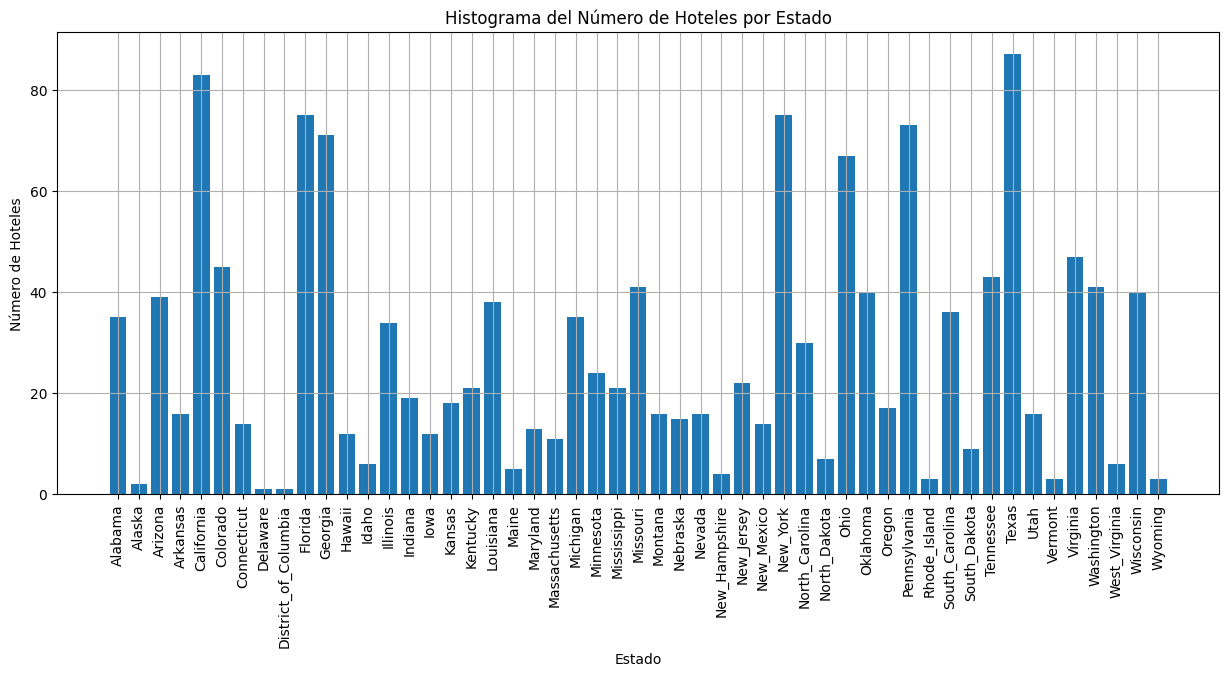

In [45]:
plt.figure(figsize=(15, 6))
plt.bar(num_hotels['state'], num_hotels['num_hotels'])
plt.xlabel('Estado')
plt.ylabel('Número de Hoteles')
plt.title('Histograma del Número de Hoteles por Estado')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Se observa que la mayor cantidad de hoteles se encuentra en el estado de Texas con un total de 87, seguido de California con 83, New York y Florida con 75; por otra parte los estados que tienen una menor cantidad son Delaware y Distric_of_Columbia con 1 hotel en total.

También se calcula y visualiza la cantidad de reviews u opiniones de los usuarios por año.

In [62]:
num_reviews_year = df_reviews.groupby(df_reviews['time_user'].apply(lambda x: x.year))['text_user'].count().reset_index(name='num_reviews')
num_reviews_year

,time_user,num_reviews
0,2007,2
1,2008,3
2,2009,2
3,2010,10
4,2011,43
5,2012,73
6,2013,153
7,2014,216
8,2015,717
9,2016,4963


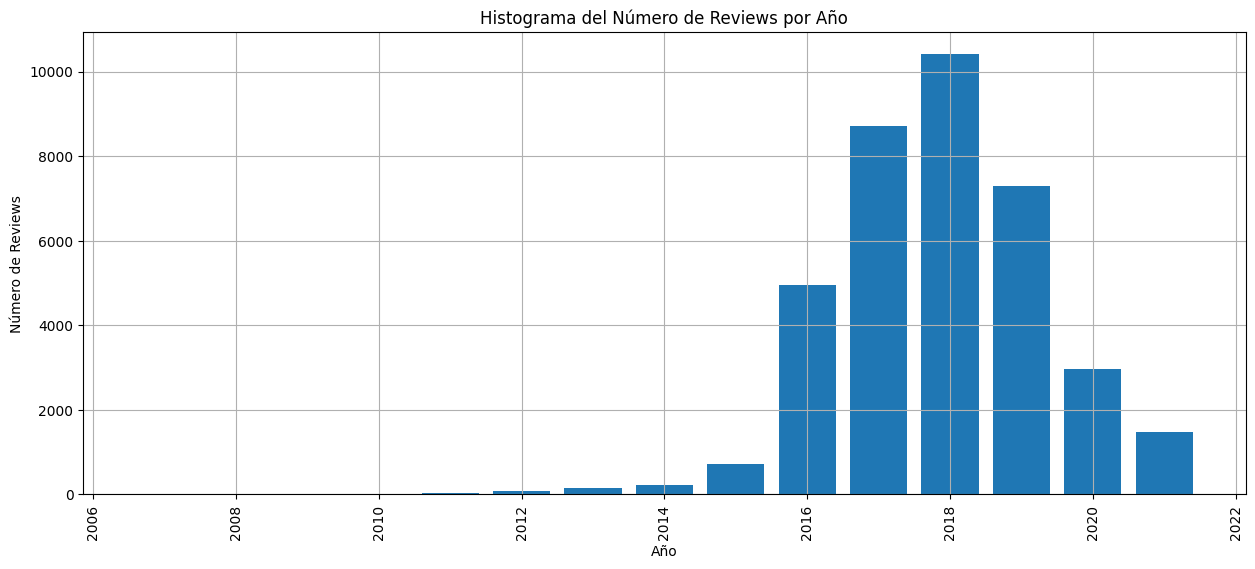

In [63]:
plt.figure(figsize=(15, 6))
plt.bar(num_reviews_year['time_user'], num_reviews_year['num_reviews'])
plt.xlabel('Año')
plt.ylabel('Número de Reviews')
plt.title('Histograma del Número de Reviews por Año')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

El año con mayor interacción de los usuarios fue el 2018 con 10405 opiniones.